# Preface
For the purpose of this assignment, the Keras library will be used for image pre-processing and model creation. Mainly, the Keras ImageDataGenerator will be used for image augmentation as well as train, validation split. 

A stratified split approach will be used to split the images into train, validation and test sets. 10% of images from each label will first be split for the test set by calling a function, while the remaining images will be split between the training and validation sets in the ratio of 80% and 20% respectively via Keras ImageDataGenerator. As such, in order for this stratified split to occur, each label needs to have at least 10 images (for the function to do the test set split).

A pre-trained model, NASNetMobile, will be used to take advantage of the pre-trained weights of bird images in ImageNet. NASNetMobile was selected for its relatively high accuracy while being lightweight, hence making it ideal for use on an Adroid device.

Note that f-strings is used in this assignment which is introduced in python v3.6.

# Question 1: Developing a model for bird classification
The following are performed:
- Handling of the dataset
- Creation and training of model
- Validation of accuracy

### Handling of the dataset: Subdirectory creation
To implement the Keras pre-processing library, the bird images will have to be classified in sub-folders according to their labels.

Please note that a new train labels file is used which had corrections made to certain misclassified images.

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

#Read the labels csv file. Ensure that the csv file is in the same folder as the notebook
df = pd.read_csv("new_trainLabels_bird.csv")

#Display labels with their image count
df.label.value_counts()

Zitting_Cisticola                    46
Stork-billed_Kingfisher              44
White-breasted_Waterhen              42
White-winged_Tern                    35
Red-Crowned_Crane                    34
                                     ..
Blyth's_Asian_Paradise_Flycatcher     2
Blue-tailed_Bee-eater                 2
Yellow_Oriole                         2
Painted_Stork                         2
Straw-headed_Bulbul                   1
Name: label, Length: 77, dtype: int64

##### Note:
- Number of labels = 77
- Different labels have different number of images. Number of images range from 1 to 46
- All images are colored and in jpg format

As discussed in the Preface above, at least 10 images are needed per label for the stratified split. As no additional images will be added to the dataset, only labels with at least 10 images are selected for this assignment.

Due to the very small dataset for each label, image augmentation is used such that the model sees a "different" image in each epoch to increase the dataset variation to prevent overfitting.

In [2]:
#Compile images of species >= 10 images
df_new = df[df["label"].map(df.label.value_counts() >= 10)]
df_new.label.value_counts()

Zitting_Cisticola               46
Stork-billed_Kingfisher         44
White-breasted_Waterhen         42
White-winged_Tern               35
Red-Crowned_Crane               34
White-bellied_Sea_Eagle         29
Jerdons_Baza                    24
Lesser_Whistling_Duck           24
Olive-backed_Sunbird            23
Common_Kingfisher               22
Grey-headed_Fish_Eagle          21
Black-winged_Kite               20
Blue-throated_Bee-eater         20
Grey-rumped_Treeswift           20
Little_Tern                     19
Banded_Woodpecker               19
Slaty-breasted_Rail             18
Sunda_Scoops_Owl                17
Yellow-vented_Bulbul            17
Black-crowned_Night_Heron       16
Sunda_Pygmy_Woodpecker          16
Buffy_Fish_Owl                  15
Green_Imperial_Pigeon           14
Oriental_Pied_Hornbill          14
Brahmini_Kite                   13
Greater_Racket-tailed_Drongo    13
Golden-backed_Weaver            13
Zanzibar_Red_Bishop             13
Blue-crowned_Hanging

In [3]:
#Function to create sub-folders for each label within the same directory
#Function heavily modified from https://www.kaggle.com/ericbenhamou/sub-directories-for-keras-flow-from-directory
def create_folders(parent_dir, train_folder_name, test_folder_name, df, categories):
    
    #Create train and test folders in the same directory
    folders = [train_folder_name, test_folder_name]
        
    for folder in folders:
        if not os.path.isdir(folder):
            os.mkdir(folder)
            print(f"Folder {folder}, created!")
        else:
            print(f"Folder {folder}, exists!")
          
    #Create labels in the train and test folders
    for folder in folders:
        for i in categories:
            subfolder = str(i)
            path = os.path.join(f"{parent_dir}/" + folder, subfolder)
            if not os.path.isdir(path):
                os.mkdir(path)
            else:
                print(f"Folder {i}, exists in {folder}!")
    
    print(f"Folders and subfolders created for {train_folder_name} and {test_folder_name}!")

In [4]:
#Create the subfolders
parent_dir = r"C:\Users\Yong Jin\Desktop\TIPPAAI_AAISD_CV_Chong Yong Jin"
train_folder_name = "train"
test_folder_name = "test"
categories = np.unique(df_new.label.values)

create_folders(parent_dir, train_folder_name, test_folder_name, df_new, categories) #Input df here

Folder train, created!
Folder test, created!
Folders and subfolders created for train and test!


In [5]:
#Function to move images to train subfolders
#Function modified from https://www.kaggle.com/ericbenhamou/sub-directories-for-keras-flow-from-directory
def move_files(path, train_folder_name, df, map_dict):
    failed = 0
    
    for root, dirs, files in os.walk(path, topdown = True):
        for name in files:
            oldfile = os.path.join(root, name)
            newfile = os.path.join(f"{train_folder_name}/"+ map_dict[name[:-4]], name) #Slice out the ".jpg" from filename
                                   
            if not os.path.isdir(newfile):
                try:
                    os.rename(oldfile, newfile)
                    
                except:
                    failed += 1
    
    print("Completed transfer of images to train subfolders.")
    print(f"Failed to move {failed} images!")

In [6]:
#Call the functions to move images to train subfolders
#Note that images not in the selected labels will not be moved
'''
    Please note that the images will be moved from the same folder directory as the notebook.
    Hence, please ensure that a copy of the "bird" folder containing the images is present in the folder before calling the function.
'''

path = "birds" #Directory
map_dict = dict(df.values.tolist()) #Create dictionary of filename: labels for mapping

move_files(path, train_folder_name, df_new, map_dict) #Input df here

#Check number of images not in the selected labels to verify
df_nan = df[df["label"].map(df.label.value_counts() < 10)]
print(f'{sum(df_nan.label.value_counts())} images are not in the selected criteria.')

Completed transfer of images to train subfolders.
Failed to move 178 images!
178 images are not in the selected criteria.


In [7]:
#Function to move images to test subfolders
#Function modified from https://www.kaggle.com/ericbenhamou/sub-directories-for-keras-flow-from-directory
def move_test_images(train_folder_name, test_folder_name, df, test_ratio):
       
    for root, dirs, files in os.walk(train_folder_name, topdown = True):
        failed = 0
        train_num = len(files)
        
        if train_num == 0:
            continue
        
        test_num = 0
                 
        for name in files:
            oldfile = os.path.join(root, name)
            newfile = os.path.join(f"{test_folder_name}/" +
                                   root[len(train_folder_name) + 1:], 
                                   name)
            
            test_num += 1
                    
            if test_ratio < test_num / train_num: 
                continue #If test ratio met, move to the next subfolder
            
            if not os.path.isdir(newfile):
                try:
                    os.rename(oldfile, newfile)
                    
                except:
                    failed += 1
        
        if failed > 0:
            print(f"Failed to move {failed} files in {root}")
    
    print("Completed transfer of images to test subfolders.")

In [8]:
#Call the functions to split images to test subfolders
test_ratio = 0.1

move_test_images(train_folder_name, test_folder_name, df, test_ratio)

Completed transfer of images to test subfolders.


In [9]:
#Check that image mapping is correct
#Function code extracted from https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")

#Check that the list of images for Yellow_Bittern and Brahmini_Kite is correct
checklist = ["Yellow_Bittern", "Brahmini_Kite"]

list_files(f"train/{checklist[0]}")
list_files(f"test/{checklist[0]}")
list_files(f"train/{checklist[1]}")
list_files(f"test/{checklist[1]}")

Yellow_Bittern/
    _JWO1459_cr.jpg
    _JWO1463_cr.jpg
    _JWO1477_cr_cr.jpg
    _JWO1483_cr.jpg
    _JWO1484_cr.jpg
    _JWO1485_cr.jpg
    _JWO1486_cr.jpg
    _JWO1506_cr.jpg
    _JWO1548_cr.jpg
Yellow_Bittern/
    _JWO1450_cr.jpg
Brahmini_Kite/
    _JWO0528_cr.jpg
    _JWO8855_cr.jpg
    _JWO8856_cr.jpg
    _JWO8859_cr.jpg
    _JWO9897_cr.jpg
    _JWO9898_cr.jpg
    _JWO9899_cr.jpg
    _JWO9904_cr.jpg
    _JWO9919_cr.jpg
    _JWO9925_cr.jpg
    _JWO9926_cr.jpg
    _JWO9930_cr.jpg
Brahmini_Kite/
    _JWO0526_cr.jpg


In [10]:
#Check the filename against the DataFrame mapping
df_new.query(f"label in {checklist}")

,filename,label
55,_JWO0526_cr,Brahmini_Kite
56,_JWO0528_cr,Brahmini_Kite
94,_JWO1450_cr,Yellow_Bittern
95,_JWO1459_cr,Yellow_Bittern
96,_JWO1463_cr,Yellow_Bittern
97,_JWO1477_cr_cr,Yellow_Bittern
99,_JWO1483_cr,Yellow_Bittern
100,_JWO1484_cr,Yellow_Bittern
101,_JWO1485_cr,Yellow_Bittern
102,_JWO1486_cr,Yellow_Bittern


##### Note
The image names of the 2 labels in the subfolders matches the label mapping in the DataFrame. Image transfer was sucessful.

### Handling of the dataset: Preprocessing and image augmentation
* As the model used is NASNetMobile, the respective preprocessing method will be used.
* Keras library is also utilised for the image augmentation during training.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input

#Image augmentation parameters for training set
train_params = ImageDataGenerator(
                   rotation_range = 20, 
                   brightness_range = (0.5, 1.5), 
                   shear_range = 30, 
                   zoom_range = (0.8, 1.2), 
                   fill_mode = "nearest", 
                   horizontal_flip = True,
                   validation_split = 0.2,
                   preprocessing_function = preprocess_input) #Using NASNetMobile's preprocessing method

#Creating the image augmentation
#Change directory as necessary
direc = r"C:\Users\Yong Jin\Desktop\TIPPAAI_AAISD_CV_Chong Yong Jin\train" 

labels = np.unique(df_new.label.values).tolist()

#Training set
train_gen = train_params.flow_from_directory(
                    directory = direc,
                    target_size = (224, 224), #Using the default image size of NASNetMobile for optimal results
                    color_mode = "rgb",
                    classes = labels,
                    class_mode = "categorical",
                    batch_size = 32,
                    shuffle = True,
                    seed = 2020,
                    subset = "training")

Found 534 images belonging to 36 classes.


In [12]:
#Image augmentation parameters for validation set (no augmentation of data)
valid_params = ImageDataGenerator(
                   validation_split = 0.2,
                   preprocessing_function = preprocess_input) #Using NASNetMobile's preprocessing method

#Validation set
valid_gen = valid_params.flow_from_directory(
                    directory = direc,
                    target_size = (224, 224), #Using the default image size of NASNetMobile for optimal results
                    color_mode = "rgb",
                    classes = labels,
                    class_mode = "categorical",
                    batch_size = 32,
                    shuffle = True,
                    seed = 2020,
                    subset = "validation")

Found 116 images belonging to 36 classes.


In [13]:
#Verify that all labels have at least 1 validation image
for i in range(len(labels)):
    if valid_gen.classes.tolist().count(i) < 1:
        print(f"Missing validation image from {list(valid_gen.class_indices.keys())[i]}")

In [14]:
#Image augmentation parameters for test set (Implementing Test Time Augmentation)
test_params = train_params = ImageDataGenerator(
                   preprocessing_function = preprocess_input) #Using NASNetMobile's preprocessing method

#Change directory as necessary
test_direc = r"C:\Users\Yong Jin\Desktop\TIPPAAI_AAISD_CV_Chong Yong Jin\test"

#Validation set
test_gen = test_params.flow_from_directory(
                    directory = test_direc,
                    target_size = (224, 224), #Using the default image size of NASNetMobile for optimal results
                    color_mode = "rgb",
                    classes = labels,
                    class_mode = "categorical",
                    batch_size = 32,
                    shuffle = False,
                    seed = 2020)

Found 58 images belonging to 36 classes.


In [15]:
#Verify that all labels have at least 1 test image
for i in range(len(labels)):
    if test_gen.classes.tolist().count(i) < 1:
        print(f"Missing validation image from {list(test_gen.class_indices.keys())[i]}")

##### Note:
* All labels have at least 1 image for validation and testing.

### Creation and training of model
- Using NASNetMobile as base model
- Include a pooling layer and fully connected layer

In [16]:
#Setting up the NASNetMobile base model
inputs = (224, 224, 3)
base_model = NASNetMobile(include_top = False, weights = "imagenet", input_shape = inputs, pooling = "average")

for layer in base_model.layers[:]:
    layer.trainable = False

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(36, activation = "softmax"))

model.compile(optimizer = Adam(), 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

#Early stopping monitor if validation loss doesn't improve after 3 epochs to prevent overfitting 
#Save out the best model with the highest valuation accuracy
def scheduler(epoch):
    if epoch < 10:
        return 0.01
    if epoch < 20:
        return 0.001
    else:
        return 0.0001

callback = [EarlyStopping(monitor = "val_loss", patience = 3, mode = "min"),
            ModelCheckpoint(filepath = "best_model.hdf5", monitor = "val_loss", save_best_only = True),
            LearningRateScheduler(scheduler)]

#Fit the model
bird_model = model.fit(train_gen, 
                      epochs = 3, #Note that epoch was set to 3 to reduce computation time since the best model has already been saved out
                      shuffle = True,
                      validation_data = valid_gen,
                      callbacks = callback,
                      verbose = 1)

Epoch 1/3
17/17 [==============================] - 33s 2s/step - loss: 2.1179 - accuracy: 0.5243 - val_loss: 0.8447 - val_accuracy: 0.7328 - lr: 0.0100
Epoch 2/3
17/17 [==============================] - 32s 2s/step - loss: 0.4620 - accuracy: 0.8371 - val_loss: 0.5606 - val_accuracy: 0.8276 - lr: 0.0100
Epoch 3/3
17/17 [==============================] - 32s 2s/step - loss: 0.3564 - accuracy: 0.8839 - val_loss: 0.4057 - val_accuracy: 0.8621 - lr: 0.0100


In [19]:
#Save the history of the best model
data = bird_model.history

with open("model_history.pickle", 'wb+') as out_file:
    pickle.dump(data, out_file)

##### Note
The initial model resulted in a high validation accuracy of 0.9397 with a validation loss of 0.3158 at epoch 30. Hence, only minimal tuning was implemented. Moreover, ImageNet results has shown that NASNetMobile will not have a significantly high accuracy as compared to other models such as NASNetLarge, hence further fine-tuning would not have a meaningful or significant impact to the performance.

The following parameters were tuned:
* A stepped learning rate was used for the optimizer Adam. This allows the model to learn more optimal weights via a smaller step size as the loss gradient decreases.

The resulting model was saved out by the ModelCheckpoint callback and renamed as "bird_model_best.hdf5" to prevent over-writing. The history of the model was saved and renamed as "bird_model_history.pickle" to prevent over-writing.

In [20]:
#Loading the saved best model
from tensorflow.keras.models import load_model

saved_model = load_model("bird_model_best.hdf5")

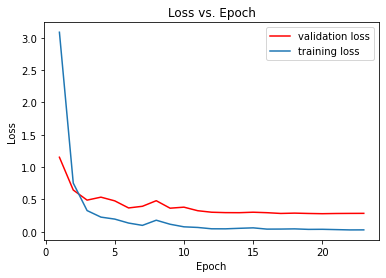

In [21]:
#Loading the saved instanced history of the saved model
with open("bird_model_history.pickle", "rb") as in_file:
    saved_model_history = pickle.load(in_file)

#Define the function of the loss graphs of the saved model
def plot_loss(model):
    train_acc = model["loss"]
    test_acc = model["val_loss"]
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = "red", label = "validation loss")
    plt.plot(x, train_acc, label = 'training loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epoch")
    plt.legend()
    
#Plot the loss graphs
plot_loss(saved_model_history)

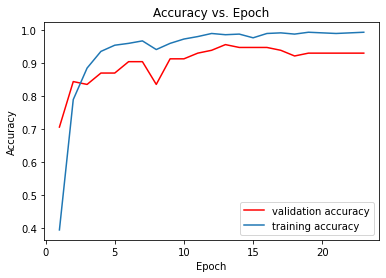

In [22]:
#Loading the saved instanced history of the saved model
with open("bird_model_history.pickle", "rb") as in_file:
    saved_model_history = pickle.load(in_file)

#Define the function of the loss graphs of the saved model
def plot_accuracy(model):
    train_acc = model["accuracy"]
    test_acc = model["val_accuracy"]
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = "red", label = "validation accuracy")
    plt.plot(x, train_acc, label = 'training accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epoch")
    plt.legend()
    
#Plot the loss graphs
plot_accuracy(saved_model_history)

##### Note:
The validation loss improved slightly after fine-tuning the model. The lowest validation loss of 0.2794 was recorded at epoch 20, which had a validation accuracy of 0.9310. Model training was terminated at epoch 23 by the callback ModelCheckpoint as there was no further reduction in the validation loss.

### Validation of accuracy
The trained model will be tested using the test set and evaluated using the performance metric Recall. Recall is used since the objective is to determine out of all the images of a particular label, how many were correctly identified as that label. 

<img src = "images for notebooks/Recall.png">

In [23]:
#Evaluate the test images using the saved model
pred = saved_model.predict(test_gen)

In [24]:
from sklearn.metrics import classification_report, accuracy_score

#Convert the labels from array matrix to list of predicted and actual labels
class_names = list(test_gen.class_indices)

y_pred = [class_names[i] for i in list(np.argmax(pred, axis = -1))]
y_true = [class_names[i] for i in test_gen.classes.tolist()]

In [25]:
#Print the classification report of the birds
print(classification_report(y_true, y_pred, zero_division = 0))

                              precision    recall  f1-score   support

           Banded_Woodpecker       1.00      1.00      1.00         1
   Black-crowned_Night_Heron       0.50      1.00      0.67         1
           Black-winged_Kite       0.00      0.00      0.00         2
 Blue-crowned_Hanging_Parrot       1.00      1.00      1.00         1
     Blue-throated_Bee-eater       1.00      1.00      1.00         2
            Blue-winged_Pita       1.00      1.00      1.00         1
               Brahmini_Kite       0.33      1.00      0.50         1
              Buffy_Fish_Owl       1.00      1.00      1.00         1
           Common_Kingfisher       1.00      1.00      1.00         2
        Golden-backed_Weaver       1.00      1.00      1.00         1
Greater_Racket-tailed_Drongo       1.00      1.00      1.00         1
       Green_Imperial_Pigeon       1.00      1.00      1.00         1
      Grey-headed_Fish_Eagle       1.00      1.00      1.00         2
       Grey-rumped_

##### Evaluation:

* The number of test images per label (support) is indicative of how large the training set is for the particular image.

* Overall weighted average recall is at 0.90, which is slightly lower than the validation accuracy of 0.93. This can be attributed to the smaller number of data in the test set (58 images) as compared to the validation set (116 images), which skews the accuracy for each misclassification.

* From a comparison of the predicted labels and true labels, it can be seen that the overall small dataset resulted in similar looking birds having higher rates of misclassifications. For instance, the "black-winged kite" birds (_JWO9527_cr.jpg and _JWO9528_cr.jpg) were misclassified as "Brahmini Kite" (a close species). The "Red-Crowned_Crane" (_JWO5310_cr.jpg) was misclassified as "Whooper_Swan" due to the close resemblance (bird color and background color).

* It can be seen that although using data augmentation had generally resulted in a decent Recall, it cannot fully mitigate the lack of variation of data from a small dataset.